# Исследование надёжности заёмщиков

## Вводные данные

**Цель:** Создать модель, предсказывающую способность заёмщика погасить кредит в срок.

**Задачи:**
1. Загрузить и проананализировать данные;
2. Провести предобработку данных и подготовить признаки;
4. Построить модель; 
5. Сделать выводы;

**Данные для работы:** /datasets/data.csv

**Описание данных:**
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

<a id='back-bullet'></a>

## Содержание
* [1. Загрузка и первичный анализ данных](#download-bullet)
* [2. Предобработка данных и подготовка признаков](#rework-bullet)
* [3. Создание модели](#model-bullet)
* [4. Общий вывод](#conclusion-bullet)

<a id='download-bullet'></a>

## 1. Загрузка и первичный анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymystem3 import Mystem
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('/datasets/data.csv')
#C:/Users/drtar/Documents/Data Science/Projects/Pet projects/data_1.csv

In [3]:
def full_info(data):
    print(' * ' * 20)
    print('Размер датафрейма:', data.shape)
    print('Количество дубликатов:', data.duplicated().sum())
    tab = pd.concat([data.dtypes, data.isna().sum(), data.isna().mean()*100], axis=1)
    tab.columns=['data_type', 'nan_count','nan_part, %']
    display(tab.sort_values(by='nan_count', ascending=False))    
    display(data.sample(5))
    display(data.describe())    
    print(' * ' * 20)

In [4]:
full_info(data)

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Размер датафрейма: (21525, 12)
Количество дубликатов: 54


,data_type,nan_count,"nan_part, %"
days_employed,float64,2174,10.099884
total_income,float64,2174,10.099884
children,int64,0,0.000000
dob_years,int64,0,0.000000
education,object,0,0.000000
education_id,int64,0,0.000000
family_status,object,0,0.000000
family_status_id,int64,0,0.000000
gender,object,0,0.000000
income_type,object,0,0.000000


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
755,2,-406.684740,32,высшее,0,в разводе,3,F,госслужащий,0,318047.093421,покупка жилой недвижимости
5412,0,-1376.543176,56,среднее,1,женат / замужем,0,F,компаньон,0,134878.500272,на покупку своего автомобиля
13208,0,-1730.003597,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,65757.567332,автомобили
6794,0,-995.218568,29,высшее,0,Не женат / не замужем,4,F,компаньон,0,282634.267195,образование
1158,0,354977.894588,64,СРЕДНЕЕ,1,вдовец / вдова,2,F,пенсионер,0,72777.895655,приобретение автомобиля


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


* 21525 строк с данными и 12 признаков (7 численных и 5 - категориальных), где **debt** - целевой. Категориальные признаки следуют преобразовать в численные с помощью прямого и порядкового кодирования, так как логистическая регрессия воспринимает только численные признаки;
* 54 дубликата в данных;
* Одинаковое кол-во пропусков в признаках days_employed и total_income  - 2174 шт. (10,1 %). Необходимо проверить, как связаны пропуски по данным признакам между собой и обработать их;
* Признаки education и education_id, family_status и family_status_id дублируют друг друга, следует исключить family_status и education из анализа, но перед этим для удобства нужно сделать два справачных датафрейма по данным парам признаков.
* children -  отрицательные значения, максимум 20. Вероятно, ошибки при заполнении формы или выгрузке данных.Заменить или удалить данные, сделать категоризацию;
* days_employed - пропуски, отрицательные значения, существенное различие между средней и медианой. Вероятно, ошибки при выгрузке данных. Заменить или удалить данные, перевести в года, сделать категоризацию;
* dob_years	- нули. Вероятно, замена пропущенных значений. Медиана и среднее примерно одинаковы - данные распределены нормально. Заменить или удалить данные, сделать категоризацию;
* gender - проверить разделение категорий на адекватность;
* income_type - проверить разделение категорий на адекватность;
* total_income - пропуски. Медиана и среднее примерно одинаковы - данные распределены нормально. Заменить или удалить данные, сделать категоризацию.



[Вернуться к содержанию](#back-bullet)

<a id='rework-bullet'></a>

## 2. Предобработка данных и подготовка признаков

**education_id, family_status_id**

In [5]:
data['education'] = data['education'].str.lower()
data['family_status'] = data['family_status'].str.lower()
education = data.pivot_table(index = 'education', 
                               values = 'education_id', 
                               aggfunc = 'mean').sort_values(by = 'education_id')
family = data.pivot_table(index = 'family_status', 
                            values = 'family_status_id', 
                            aggfunc = 'mean').sort_values(by = 'family_status_id')
display(education)
display(family)

,education_id
education,
высшее,0
среднее,1
неоконченное высшее,2
начальное,3
ученая степень,4


,family_status_id
family_status,
женат / замужем,0
гражданский брак,1
вдовец / вдова,2
в разводе,3
не женат / не замужем,4


***Заметка для разработчиков формы:*** сделать выбор ответа для данных признаков списком, что избежать размножения категорий в будущем.

**Children**

In [6]:
data.loc[data['children'] == -1,'children'] = 1
data.loc[data['children'] >= 10,'children'] = data.loc[data['children'] >= 10,'children']/10

In [7]:
def childs_group(child):
        if child == 0:
                return 'бездетный'
        if child < 3:
                return '1-2 ребёнка'
        return 'многодетный'
data['children_status'] = data['children'].apply(childs_group)
print(data['children_status'].value_counts())

бездетный      14149
1-2 ребёнка     6996
многодетный      380
Name: children_status, dtype: int64


***Заметка для разработчиков формы:*** проверить работу системы. Исключить варианты заполнения формы отрицательными значениями и значениями < 10.

**days_employed, total_income**

Количество строк, где есть пропуски в обоих признаках:

In [8]:
data[(data['days_employed'].isnull()) & (data['total_income'].isnull())]['children'].count()

2174

Кол-во строк с пропусками по 2-м признакам совпадает с кол-вом строк с пропусками по каждому признаку в отдельности. Возможно, строки соответствуют заёмщикам, которые не работают. Проверяем:

In [9]:
data[(data['days_employed'].isnull()) & (data['total_income'].isnull())]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Предположение не подтвердилось. Вероятно, пропуски связаны с неккоректным заполнением форм, либо с ошибкой выгрузки данных с сервера. Исключаем строки с пропусками из анализа:

In [10]:
data = data.dropna()

Рассмотрим выборки положительных и отрицательных значений признака days_employed:

In [11]:
data[data['days_employed'] >= 0]['days_employed'].describe()

count      3445.000000
mean     365004.309916
std       21075.016396
min      328728.720605
25%      346639.413916
50%      365213.306266
75%      383246.444219
max      401755.400475
Name: days_employed, dtype: float64

In [12]:
data[data['days_employed'] < 0]['days_employed'].describe()

count    15906.000000
mean     -2353.015932
std       2304.243851
min     -18388.949901
25%      -3157.480084
50%      -1630.019381
75%       -756.371964
max        -24.141633
Name: days_employed, dtype: float64

Отрицательная выборка варьируется в диапозоне значений от 2-го до 5-го порядка. Положительная выборка состоит из значений 6-го порядка, что говорит об ошибке выгрузки данных - вероятно, данные указаны в часах. Преобразуем отрицательные значения в положительные и дни (часы) в года:

In [13]:
data.loc[data['days_employed'] > 0, 'days_employed'] = data.loc[data['days_employed'] > 0,'days_employed']/24
data['days_employed']  = round(abs(data['days_employed']),0)
data['year_employed']  = round(abs(data['days_employed']/365),1) 

In [14]:
data['year_employed'].describe()

count    19351.000000
mean        12.716924
std         14.674016
min          0.100000
25%          2.500000
50%          6.000000
75%         15.200000
max         50.400000
Name: year_employed, dtype: float64

Значения адекватны. Проведём категоризацию:

In [15]:
def year_group(year):
        if year == 0:
                return 'не работал'
        if 0 < year <= 1:
                return 'первый опыт'
        if 1 < year <= 3:
                return 'маленький стаж'    
        if 3 < year <= 5:
                return 'средний стаж'
        if 5 < year <= 10:
                return 'большой стаж'
        return 'сверхбольшой стаж'
data['year_employed_status'] = data['year_employed'].apply(year_group)
print(data['year_employed_status'].value_counts())

сверхбольшой стаж    6576
большой стаж         4080
маленький стаж       3881
средний стаж         2886
первый опыт          1928
Name: year_employed_status, dtype: int64


Проведём категоризацию признака total_income (согласно: https://zen.yandex.ru/media/dogecrypto/kak-poschitat-k-kakomu-klassu-vy-otnosites-po-urovniu-dohoda-5b150b5aea0fe700a848e1b1):

In [16]:
def total_income_group(year):
        if 0 < year <= 10000:
                return 'малоимущий'
        if 10000 < year <= 15000:
                return 'беднейший'    
        if 15000 < year <= 18000:
                return 'бедный'
        if 18000 < year <= 36000:
                return 'выше бедности'
        if 36000 < year <= 100000:
                return 'нижний средний класс'    
        if 100000 < year <= 150000:
                return 'предсредний класс'
        if 150000 < year <= 250000:
                return 'средний класс'
        if 250000 < year <= 500000:
                return 'верхний средний класс'    
        return 'богатый'
data['group_income'] = data['total_income'].apply(total_income_group)
print(data['group_income'].value_counts())


средний класс            6372
предсредний класс        5704
нижний средний класс     4388
верхний средний класс    2590
богатый                   222
выше бедности              75
Name: group_income, dtype: int64


**dob_years**

Посчитаем количство заёмщиков с возрастом меньше 18 лет, так как кредит разрешено брать только с этого возраста (https://www.sravni.ru/enciklopediya/info/so-skolki-let-dajut-kredit/#:~:text=Гражданам%20Российской%20Федерации%20разрешается%20брать,требуемой%20суммы%20и%20срока%20кредитования)

In [17]:
data[data['dob_years'] < 18]['dob_years'].value_counts()

0    91
Name: dob_years, dtype: int64

Вероятно, нули - это замена пропущенных значений. Исключаем их:

In [18]:
data = data.query('dob_years >= 18')

Категоризация (согласно: http://ido.samgtu.ru/images/TeacherFiles/Programms/Dist/Health_4.pdf):

In [19]:
def dob_year_group(year):
        if 18 <= year <= 28:
                return 'молодёжный возраст'
        if 28 < year <= 39:
                return '1-й период зрелого возраста'
        if 39 < year < 59:
                return '2-й период зрелого возраста'
        return 'пожилой возраст'
data['dob_year_status'] = data['dob_years'].apply(dob_year_group)
print(data['dob_year_status'].value_counts())

2-й период зрелого возраста    8602
1-й период зрелого возраста    5604
пожилой возраст                2665
молодёжный возраст             2389
Name: dob_year_status, dtype: int64


**gender**

In [20]:
data['gender'].value_counts()

F      12688
M       6571
XNA        1
Name: gender, dtype: int64

Вероятно, XNA - заполнение пропущенного значения. Исключаем его:

In [21]:
data = data[data['gender'] != 'XNA']

**income_type**

In [22]:
data['income_type'].value_counts()

сотрудник          9964
компаньон          4558
пенсионер          3426
госслужащий        1306
безработный           2
студент               1
предприниматель       1
в декрете             1
Name: income_type, dtype: int64

Видим 8 категорий, при этом 4 из них на 3 порядка меньше остальных. Кол-во категорий следует уменьшить для улучшения качества модели: объединим сотрудников, госслужищих и в декрете в одну категорию 'Работник', компаньонов и предпренимателей в категорию 'Бизнесмен', студентов и безработных в категорию 'Безработный'. Категорию 'Пенсионер' оставляем без изменений:

In [23]:
data.loc[data['income_type'] == 'в декрете','income_type'] = 'сотрудник'
data.loc[data['income_type'] == 'компаньон','income_type'] = 'бизнесмен'
data.loc[data['income_type'] == 'предприниматель','income_type'] = 'бизнесмен'
data.loc[data['income_type'] == 'студент','income_type'] = 'безработный'
data['income_type'].value_counts()

сотрудник      9965
бизнесмен      4559
пенсионер      3426
госслужащий    1306
безработный       3
Name: income_type, dtype: int64

***Заметка для разработчиков формы:*** уменьшить кол-во категорий. Сделать выбор вариантов ответа списком.

**Purpose**

In [24]:
data['purpose'].value_counts()

свадьба                                   717
сыграть свадьбу                           688
на проведение свадьбы                     682
операции с недвижимостью                  612
покупка коммерческой недвижимости         594
покупка жилья                             589
покупка жилья для сдачи                   586
жилье                                     583
операции с коммерческой недвижимостью     580
строительство жилой недвижимости          577
операции с жильем                         573
покупка своего жилья                      573
недвижимость                              570
покупка жилья для семьи                   569
строительство недвижимости                561
операции со своей недвижимостью           559
строительство собственной недвижимости    558
покупка недвижимости                      549
покупка жилой недвижимости                544
ремонт жилью                              541
автомобиль                                450
на покупку своего автомобиля      

Необходимо уменьшить кол-во категорий с помощью лемматизации. 

In [25]:
m = Mystem()
text = ['свадьба','жилье','недвижимость','автомобиль','образование']
def slovo(i): 
    lemma = m.lemmatize(i) 
    for n in text: 
        if n in lemma:
            lemma = n 
    return lemma 
data.loc[:,'purpose'] = data['purpose'].apply(slovo)
data['purpose'].value_counts()

недвижимость    5704
жилье           4014
автомобиль      3875
образование     3579
свадьба         2087
Name: purpose, dtype: int64

***Заметка для разработчиков формы:*** уменьшить кол-во категорий для выбора. Сделать выбор вариантов ответа списком.

**debt**

In [26]:
data['debt'].value_counts()

0    17696
1     1563
Name: debt, dtype: int64

Должников на порядок меньше. При моделировании стоит применить upsampling.

**Обработка дубликатов**

In [27]:
print('Количество дубликатов в данных:', data.duplicated().sum())
data = data.drop_duplicates()
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 0
Количество дубликатов в данных: 0


**Кодирование** <a id='type-bullet'></a>

In [28]:
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_status,year_employed,year_employed_status,group_income,dob_year_status
20996,0.0,6290.0,41,среднее,1,женат / замужем,0,M,сотрудник,0,219389.360402,образование,бездетный,17.2,сверхбольшой стаж,средний класс,2-й период зрелого возраста
20255,2.0,1044.0,43,высшее,0,женат / замужем,0,M,бизнесмен,0,521125.408255,недвижимость,1-2 ребёнка,2.9,маленький стаж,богатый,2-й период зрелого возраста
16326,1.0,869.0,34,среднее,1,женат / замужем,0,F,сотрудник,0,182095.380127,недвижимость,1-2 ребёнка,2.4,маленький стаж,средний класс,1-й период зрелого возраста
1283,0.0,7391.0,53,среднее,1,женат / замужем,0,F,сотрудник,0,133877.820009,жилье,бездетный,20.2,сверхбольшой стаж,предсредний класс,2-й период зрелого возраста
5923,0.0,3508.0,38,среднее,1,женат / замужем,0,F,сотрудник,0,59550.789462,недвижимость,бездетный,9.6,большой стаж,нижний средний класс,1-й период зрелого возраста


Перед кодированием исключаем дублируещиеся признаки: 'children', 'days_employed', 'dob_years', 'education', 'family_status', 'total_income', 'year_employed' - и делаем переиндексацию:

In [29]:
data = data.drop(['children', 
                 'days_employed', 
                 'dob_years', 
                 'education', 
                 'family_status', 
                 'total_income', 
                 'year_employed'], axis = 1).reset_index().drop(['index'], axis = 1)

In [30]:
data.sample(5)

,education_id,family_status_id,gender,income_type,debt,purpose,children_status,year_employed_status,group_income,dob_year_status
2328,1,1,M,госслужащий,0,свадьба,1-2 ребёнка,сверхбольшой стаж,средний класс,1-й период зрелого возраста
15356,1,0,F,сотрудник,0,автомобиль,бездетный,сверхбольшой стаж,средний класс,2-й период зрелого возраста
7641,1,4,F,пенсионер,0,жилье,бездетный,сверхбольшой стаж,нижний средний класс,пожилой возраст
10986,1,0,M,бизнесмен,0,жилье,бездетный,большой стаж,верхний средний класс,2-й период зрелого возраста
905,0,4,F,бизнесмен,0,жилье,бездетный,первый опыт,средний класс,молодёжный возраст


In [31]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data),
                            columns=data.columns)

**Мультиколлинеарность**

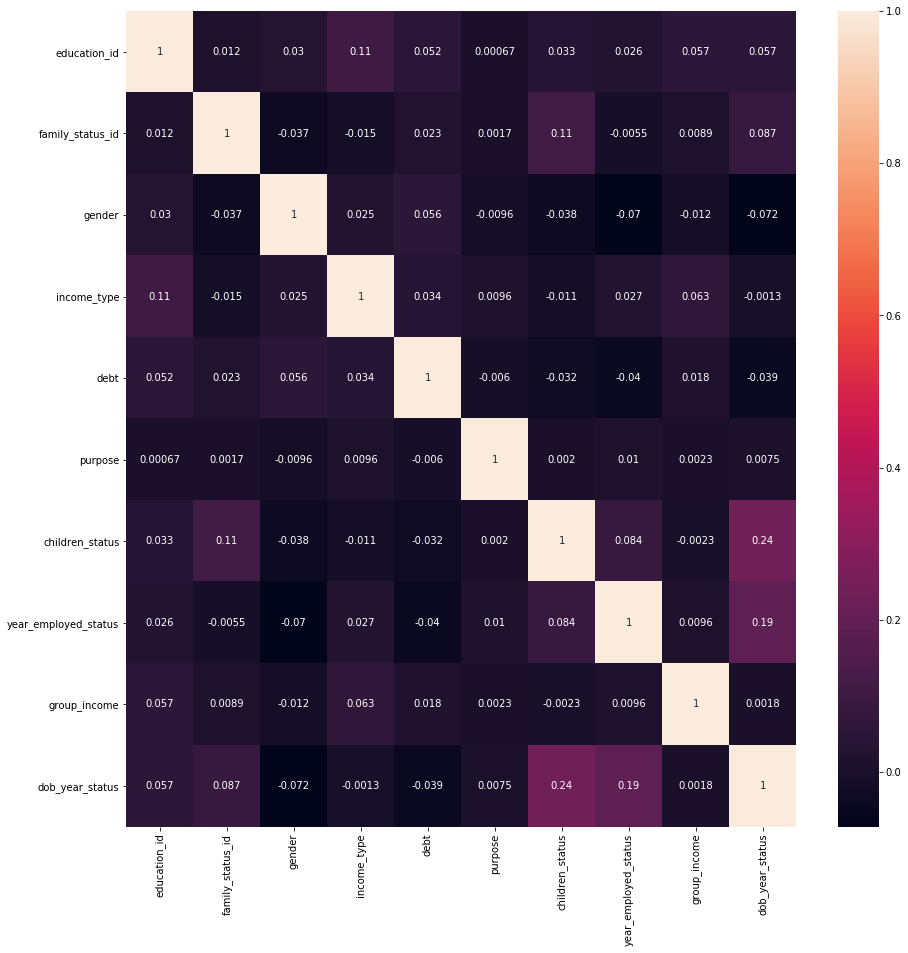

In [32]:
correlation_mat = data_ordinal.corr()  
plt.subplots(figsize=(15,15))  
sns.heatmap(correlation_mat, annot = True)  
plt.show()

Высокой корреляции между признаками нет, можно приступать к моделированию.

[Вернуться к содержанию](#back-bullet)

<a id='model-bullet'></a>

## 3. Создание модели

Выделяем признаки и целевой признак, делим данные на выборки:

In [33]:
target = data_ordinal['debt']
features = data_ordinal.drop('debt', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25, 
                                                                            random_state = 12345)

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 11)


In [35]:
target_upsampled.value_counts()

0.0    13271
1.0    12903
Name: debt, dtype: int64

Модели для сравнения: RandomForest, LogisticRegression, CatBoost, XGBoost

**RandomForest**

In [36]:
model = RandomForestClassifier()

params = {
    'n_estimators': range (10, 80, 5),
    'max_depth': range (1,20, 2),
    'min_samples_leaf': range (1,8),
    'min_samples_split': range (2,10,2) 
}

grid = RandomizedSearchCV(model, params, random_state = 12345, cv = 5)
grid.fit(features_upsampled, target_upsampled)

print('Лучший результат:')
print(grid.best_params_)
probabilities_valid_random = grid.predict_proba(features_test)
probabilities_one_test = probabilities_valid_random[:, 1]
print('Случайный лес, AUC-Roc:', roc_auc_score(target_test, probabilities_one_test))
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

Лучший результат:
{'n_estimators': 15, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 19}
Случайный лес, AUC-Roc: 0.5221170505577285


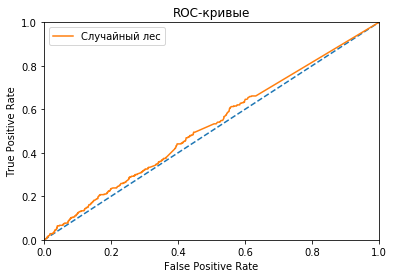

In [37]:
plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label = 'Случайный лес')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривые')
plt.show() 

**LogisticRegression**

In [38]:
model_log1 = LogisticRegression(solver = 'liblinear', random_state = 12345)
model_log1.fit(features_upsampled, target_upsampled)
probabilities_valid_log = model_log1.predict_proba(features_test)
probabilities_one_valid = probabilities_valid_log[:, 1]
print('AUC-ROC =',roc_auc_score(target_test, probabilities_one_valid))
fpr2, tpr2, thresholds2 = roc_curve(target_test, probabilities_one_valid)

AUC-ROC = 0.5946959293060987


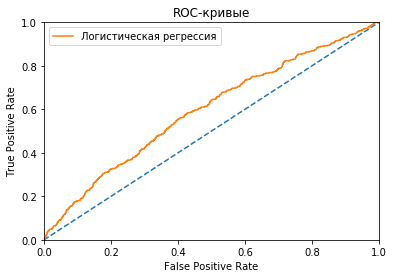

In [39]:
plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr2, tpr2, label = 'Логистическая регрессия')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривые')
plt.show() 

[Вернуться к содержанию](#back-bullet)

<a id='conclusion-bullet'></a>

## 4. Общий вывод 

[Вернуться к содержанию](#back-bullet)